<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/XGBoost/06_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import warnings

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


from sklearn.model_selection import (
    train_test_split,
    GridSearchCV)

from sklearn.metrics import (
    make_scorer,
    recall_score,
    f1_score
)

from xgboost import (
    XGBClassifier,
    XGBRegressor,
    plot_importance)

#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr

# **Functions**
---

In [24]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)


def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        ax.text(p.get_x()+p.get_width()/2., height + 1,height, ha="center")
      except:
        pass

  except Exception as e:
    print(e)

def score_mi_plot(score, features):
  """Plotting MI score"""
  plt.hlines(y=features, xmin=0, xmax=score, color='skyblue')
  plt.plot(score, features, "o")
  plt.title("Mutual Information Scores", loc='left')
  plt.xlabel('Score')
  plt.ylabel('Feature Group')


def split_test_train(

    X:pd.DataFrame,
    y:pd.Series,
    **kward)->tuple:
  """Randomly split the data into training and validation sets."""
  X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    **kward
  )
  return X_train, X_test, y_train, y_test

# **Data Dictionary**
---

Data from a cryptocurrency mining network traffic dataset is used.


- `Name`: time window name.
- `Netflows`: number of netflows in the time window.
- `First_Protocol`: top 1 of protocols used in the time window.
- `Second_Protocol`: top 2 of protocols used in the time window.
- `Third_Protocol`: top 3 protocols used in the time window.
- `p1_d`: 25% of the percentiles of all durations in the time window
- `p2_d`: 50% of the percentiles of all durations in the time window
- `p3_d`: 75% of the percentiles of all durations in the time window
- `duration`: total duration of the time window
- `max_d`: maximum value of all durations in the time window.
- `min_d`: minimum value of all durations in the time window.
- `#packets`: total number of packets in the time window.
- `Avg_bps`: average bits per second in the time window.
- `Avg_pps`: average packets per second in the time window.
- `Avg_bpp`: average bytes per packet in the time window.
- `#Bytes`: total number of bytes in the time window.
- `#sp`: total number of source ports used in the time window.
- `#dp`: total number of destination ports used in the time window.
- `first_sp`: top 1 source ports in the time window.
- `second_sp`: top 2 source ports in the time window.
- `third_sp`: top 3 source ports in the time window.
- `first_dp`: top 1 destination ports in the time window.
- `second_dp`: top 2 destination ports in the time window.
- `third_dp`: top 3 destination ports in the time window.
- `p1_ip`: 25% of the percentiles of all packet inputs  in the time window.
- `p2_ip`: 50% of the percentiles of all packet inputs  in the time window.
- `p3_ip`: 75% of the percentiles of all packet inputs  in the time window.
- `p1_ib`: 25% of the percentiles of all byte inputs in the time window.
- `p2_ib`: 50% of the percentiles of all byte inputs in the time window.
- `p3_ib`: 75% of the percentiles of all byte inputs in the time window.
- `Type`: mining time window type
  - `benignas`: 0
  - `bitcash`: 1
  - `bitcoin`: 2
  - `ethereum `: 3
  - `monero`: 4
  - `litecoin`: 5

# **Config**
---

In [25]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.5f}'.format)
random_seed = 12354
warnings.filterwarnings('ignore')


# **Config Metric**

The F1 score metric is configured to give importance to all classes

In [26]:
scoring_clasification = make_scorer(
    f1_score,
    labels = [0,1,2,3,4,5],
    average='micro'

)

The parameter dictionary is defined with:

- n_estimators: number of trees
- learning_rate: learning rate
- booster: type of booste

In [27]:
dict_params = {
    "n_estimators": [100, 300, 600, 900],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "booster": ["gbtree", "gblinear"]
}

# **Data**
---

In [28]:
url = 'https://raw.githubusercontent.com/Kaiziferr/datasets/main/cryptojacking.csv'
dta = pd.read_csv(url, dtype=str).drop([
    'Unnamed: 0',
    'Name',
    'Second_Protocol',
    'Third_Protocol'], axis=1)
dta.head(5)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,65,TCP,18.939,168.173,194.287,7845.125999999999,244.362,0.0,5546,125708,...,443,80.0,123.0,3.0,7.0,22.0,127.0,255.0,1888.0,0
1,18,UDP,0.0,0.0,0.0,0.086,0.044,0.0,20,148,...,443,53.0,53195.0,1.0,1.0,1.0,37.0,47.0,64.0,0
2,10,UDP,0.0,0.0,0.0,0.0,0.0,0.0,10,236,...,53,39308.0,54454.0,1.0,1.0,1.0,34.0,43.0,61.75,0
3,2771,UDP,0.0,0.0,0.0,8548.902,149.034,0.0,8711,129626,...,53,5355.0,443.0,1.0,1.0,1.0,39.0,49.0,54.0,0
4,2,UDP,0.0,0.0,0.0,0.0,0.0,0.0,2,328000,...,48871,53.0,NaN,1.0,1.0,1.0,37.0,41.0,45.0,0


The dataset has a class imbalance

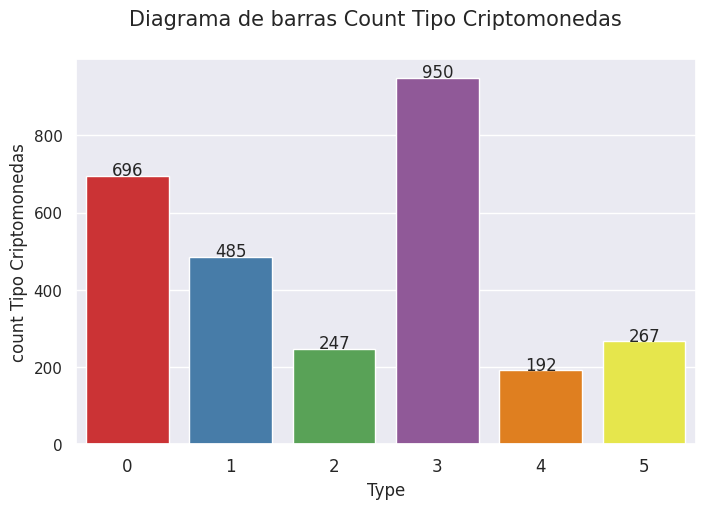

In [29]:
plot_bar(
    dta,
    paleta=None,
    ejeX='Type',
    ejey='count Tipo Criptomonedas',
    title='Count Tipo Criptomonedas')


# **Preprocessing**
---

Assigning the real data type

In [30]:
dta[[
    'p1_d', 'p2_d', 'p3_d',
    'duration', 'max_d', 'min_d',
    'Avg_bps', 'Avg_pps','Avg_bpp',
    'p1_ip', 'p2_ip', 'p3_ip',
    'p1_ib', 'p2_ib','p3_ib']] = dta[[
    'p1_d', 'p2_d', 'p3_d',
    'duration', 'max_d', 'min_d',
    'Avg_bps', 'Avg_pps','Avg_bpp',
    'p1_ip', 'p2_ip', 'p3_ip',
    'p1_ib', 'p2_ib','p3_ib']].astype('float64')

In [31]:
dta[[
    'Netflows', '#packets',
    '#Bytes', '#sp', '#dp']] = dta[[
    'Netflows', '#packets',
    '#Bytes', '#sp', '#dp']].astype('int64')

In [32]:
dta['First_Protocol'].unique()

array(['TCP', 'UDP'], dtype=object)

Categorization of the categorical variable

In [33]:
dta['First_Protocol'] = dta['First_Protocol'].replace({'TCP': 0, 'UDP':1})
dta.head(2)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,65,0,18.93900,168.17300,194.28700,"7,845.12600",244.36200,0.00000,5546,"125,708.00000",...,443,80.0,123.0,3.00000,7.00000,22.00000,127.00000,255.00000,"1,888.00000",0
1,18,1,0.00000,0.00000,0.00000,0.08600,0.04400,0.00000,20,148.00000,...,443,53.0,53195.0,1.00000,1.00000,1.00000,37.00000,47.00000,64.00000,0


dta.columns

In [34]:
dta = dta.fillna(0)

In [35]:
dta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2837 entries, 0 to 2836
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Netflows        2837 non-null   int64  
 1   First_Protocol  2837 non-null   int64  
 2   p1_d            2837 non-null   float64
 3   p2_d            2837 non-null   float64
 4   p3_d            2837 non-null   float64
 5   duration        2837 non-null   float64
 6   max_d           2837 non-null   float64
 7   min_d           2837 non-null   float64
 8   #packets        2837 non-null   int64  
 9   Avg_bps         2837 non-null   float64
 10  Avg_pps         2837 non-null   float64
 11  Avg_bpp         2837 non-null   float64
 12  #Bytes          2837 non-null   int64  
 13  #sp             2837 non-null   int64  
 14  #dp             2837 non-null   int64  
 15  first_sp        2837 non-null   object 
 16  second_sp       2837 non-null   object 
 17  third_sp        2837 non-null   o

# **CLASIFICATION**
---

In [36]:
X = dta.drop(['Type'], axis=1).select_dtypes(include=['int', 'float'])
y = dta.iloc[:, -1]
y = y.astype('int64')

Randomly split the data into training and validation sets.

In [37]:
X_train, X_test, y_train, y_test = split_test_train(X, y, **{
    "test_size": 0.25,
    "shuffle": True,
    "stratify": y,
    "random_state": random_seed
})

The model is instantiated.

In [38]:
model = XGBClassifier(
    random_state = random_seed
)

The 'GridSearchCV' is defined with 5-fold cross-validation and a modified F1 metric.



In [39]:
grid = GridSearchCV(
    model,
    dict_params,
    refit=True,
    scoring=scoring_clasification,
    cv=5,
    return_train_score=True,
    verbose = 0
)

The model is fitted



In [40]:
y.unique()

array([0, 1, 2, 3, 4, 5])

In [41]:
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=12354, ...),
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'n_estimators': [100, 300, 600, 900]},
             return_train_score=True,
             scoring=make_scorer(f1_score, response_method='predict', labels=[0, 1, 2, 3, 4, 5], average=micro))

In [42]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False).head()

,param_booster,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
7,gbtree,0.05000,900,0.95911,0.00727,1.00000,0.00000
5,gbtree,0.05000,300,0.95876,0.00555,1.00000,0.00000
8,gbtree,0.10000,100,0.95876,0.00762,0.99894,0.00045
2,gbtree,0.01000,600,0.95841,0.00761,0.99436,0.00059
11,gbtree,0.10000,900,0.95841,0.00762,1.00000,0.00000


The best parameters to tune the final model are

In [43]:
print("-----------------------------------")
print("Best hyperparameters found")
print("-----------------------------------")
print(f"{grid.best_params_} : {grid.best_score_} ({grid.scoring})")

-----------------------------------
Best hyperparameters found
-----------------------------------
{'booster': 'gbtree', 'learning_rate': 0.05, 'n_estimators': 900} : 0.9591102168566957 (make_scorer(f1_score, response_method='predict', labels=[0, 1, 2, 3, 4, 5], average=micro))


In [44]:
grid.best_score_

0.9591102168566957

In [46]:
best_model = grid.best_estimator_

# **Gain-based Importance**
---

According to the results, it can be observed that: #dp, #sp, First_Protocol, Avg_bpp, Avg_bpps, #packets, Avg_bps, Netflows. These features are the ones that contribute the most to improving the model.

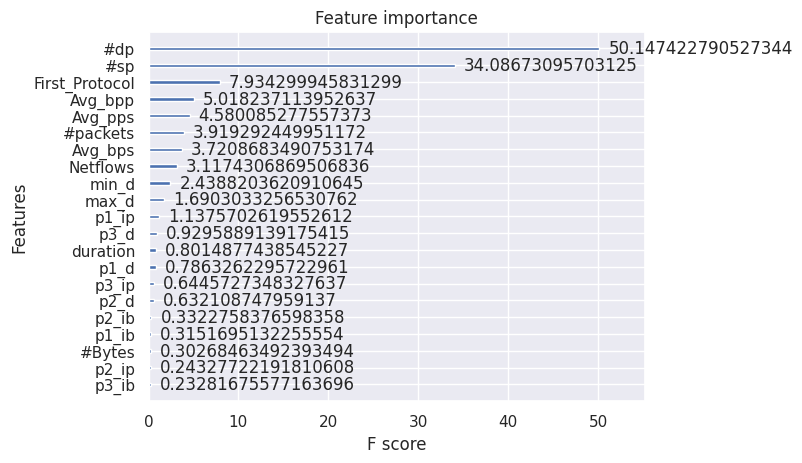

In [50]:
plot_importance(best_model, importance_type='gain')
plt.show()

# **Split-based Importance**
---

According to the results, it can be observed that: AVg_bpp, Avg_bps, p3_ip, duration, #packets, #Bytes, max_d. These features are used more frequently in the model's decision-making process, although they are not necessarily the most informative or useful in terms of performance

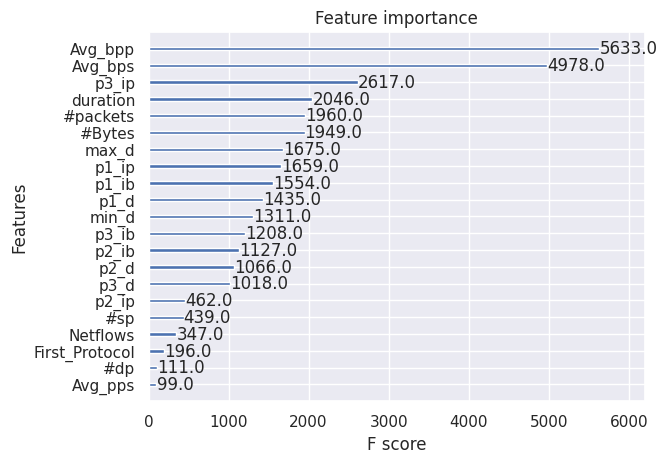

In [51]:
plot_importance(best_model, importance_type='weight')
plt.show()